In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import seaborn as sns
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
import texthero as hero
from texthero import preprocessing
sns.set_style('darkgrid')
import pyLDAvis
import pickle
import pyLDAvis.gensim_models
import string
from gensim import corpora
from pprint import pprint
import os

In [2]:
data  = []
with open("arxiv-metadata-oai-snapshot.json", 'r') as f:
    for line in f: 
        data.append(json.loads(line))
data = pd.DataFrame(data)

## 3.1 Data Wrangling

#### Filter Columns

In [3]:
# only 5 columns
cols = ['id', 'title', 'comments', 'journal-ref', 'categories']
data = data[cols]

# only records containing comments
data_comments = data[data['comments'].notnull()]

# title does not contain "COVID"
data = data_comments[~data_comments['title'].str.contains("COVID")]

In [4]:
data_copy = data.copy()

#### EDA

In [6]:
data.head()

,id,title,comments,journal-ref,categories
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,math.CO cs.CG
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,11 pages,None,math.CO
5,0704.0006,Bosonic characters of atomic Cooper pairs acro...,"6 pages, 4 figures, accepted by PRA",None,cond-mat.mes-hall


In [7]:
data.shape

(1598967, 5)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598967 entries, 0 to 2061366
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1598967 non-null  object
 1   title        1598967 non-null  object
 2   comments     1598967 non-null  object
 3   journal-ref  650361 non-null   object
 4   categories   1598967 non-null  object
dtypes: object(5)
memory usage: 73.2+ MB


#### Cleaning

In [4]:
# trim leading and trailing blanks 
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [5]:
# view duplicate IDs
data[data.duplicated(['id'])]

,id,title,comments,journal-ref,categories
1989898,math-ph/0207039,Bound State Solutions of the Dirac Equation in...,"17 pages, 3 figures, small corrections and imp...","Math. Nachr. 274-275 (2004), pages 117 - 129",math-ph gr-qc math.MP
1998270,math-ph/0212014,A semiclassically entangled puzzle,"Letter, 5 pages","J. Phys. A, 40 (2007) F1047-F1052",math-ph math.MP math.SG quant-ph
1998271,math-ph/0408005,Nonholonomic systems via moving frames: Cartan...,Dedicated to Alan Weinstein on his 60th birthd...,Progress in Mathematics 232 (2005) 75-120 [rev...,math-ph math.MP math.SG
1998272,math-ph/0409039,Moyal star product approach to the Bohr-Sommer...,"27 pages, no figures","J. Phys. A, 38 (2005) 1977-2004 [revised versi...",math-ph math.MP math.SG


In [6]:
# drop duplicate IDs
data.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [13]:
# view duplicate records excluding ID
data[data.duplicated(['title', 'comments', 'journal-ref', 'categories'])]

,id,title,comments,journal-ref,categories
156625,0911.2604,Precision Electroweak Measurements and Constra...,18 pages,None,hep-ex
169836,1001.4548,On the BICM Capacity,Submitted to the IEEE Transactions on Informat...,"IEEE Trans. Inform. Theory, vol. 57, no. 10, p...",cs.IT math.IT
170388,1001.5100,"On Exponential Sums, Nowton identities and Dic...",18 pages,None,cs.IT math.IT
177177,1003.1370,AKARI's infrared view on nearby stars : Using ...,"14 pages, 11 figures, accepted for publication...",None,astro-ph.SR
187194,1004.5254,D\'eveloppements asymptotiques combin\'es et p...,141 pages num\'erot\'ees par paires de 1 \`a 7...,None,math.DS
190732,1005.3192,"Associative Geometries. I: Torsors, linear rel...",v2: new results on relation with lattice theor...,None,math.RA
190733,1005.3193,"Associative Geometries. II: Involutions, the c...","V2: terminology changed (""torsor"" instead of ""...",None,math.RA
213297,1009.3141,Analysis of semidiscretization of the compress...,31 pages,None,math.CA
231735,1012.2367,Precision Electroweak Measurements and Constra...,18 pages,None,hep-ex
445383,1307.3655,"Photoionization Delay in He, Ne, Ar and Kr",This paper has been withdrawn by the author be...,None,physics.atom-ph


In [7]:
# drop duplicate records excluding ID
data.drop_duplicates(subset=['title', 'comments', 'journal-ref', 'categories'], keep='first', inplace=True)

In [11]:
# replace None with Numpy NaN
data = data.fillna(value=np.nan)

# reset index
data.reset_index(drop=True, inplace=True)

data.head()

,id,title,comments,journal-ref,categories,title-clean,journal-ref-clean,categories-clean
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,calculation prompt diphoton production cross s...,phys rev d76 013009 2007,hep ph
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,math.CO cs.CG,sparsity certifying graph decompositions,,math co cs cg
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,physics.gen-ph,evolution earth moon system based dark matter ...,,physics gen ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,11 pages,NaN,math.CO,determinant stirling cycle numbers counts unla...,,math co
4,0704.0006,Bosonic characters of atomic Cooper pairs acro...,"6 pages, 4 figures, accepted by PRA",NaN,cond-mat.mes-hall,bosonic characters atomic cooper pairs across ...,,cond mat mes hall


In [85]:
def clean_column(df, col, new_col):

    custom_pipeline = [preprocessing.fillna,
                    # preprocessing.remove_whitespace,
                    preprocessing.remove_diacritics,
                    preprocessing.remove_stopwords,
                    preprocessing.remove_punctuation,
                    # preprocessing.remove_digits,
                    preprocessing.lowercase,
                    # preprocessing.remove_brackets
                    ]
    # apply the custom pipeline
    df[new_col] = hero.clean(df[col], custom_pipeline)
    # remove backslash
    df[new_col] = [n.replace("\\", "") for n in df[new_col]]
    # remove whitespace between words
    df[new_col] = [" ".join(n.split()) for n in df[new_col]]
    # remove stopwords not included in hero, e.g. "a" and "on"
    stop_words = stopwords.words('english')
    df[new_col] = data[new_col].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop_words)]))
   
    return df.head()

In [86]:
# generate clean dataset
clean_column(data, 'title', 'title-clean')
clean_column(data, 'journal-ref', 'journal-ref-clean')
clean_column(data, 'categories', 'categories-clean')

,id,title,comments,journal-ref,categories,title-clean,journal-ref-clean,categories-clean,journal-year
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,calculation prompt diphoton production cross s...,phys rev d76 013009 2007,hep ph,2007
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,math.CO cs.CG,sparsity certifying graph decompositions,,math co cs cg,NaN
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,physics.gen-ph,evolution earth moon system based dark matter ...,,physics gen ph,NaN
3,0704.0004,A determinant of Stirling cycle numbers counts...,11 pages,NaN,math.CO,determinant stirling cycle numbers counts unla...,,math co,NaN
4,0704.0006,Bosonic characters of atomic Cooper pairs acro...,"6 pages, 4 figures, accepted by PRA",NaN,cond-mat.mes-hall,bosonic characters atomic cooper pairs across ...,,cond mat mes hall,NaN


## 3.2 Descriptive Analysis

#### WordCloud

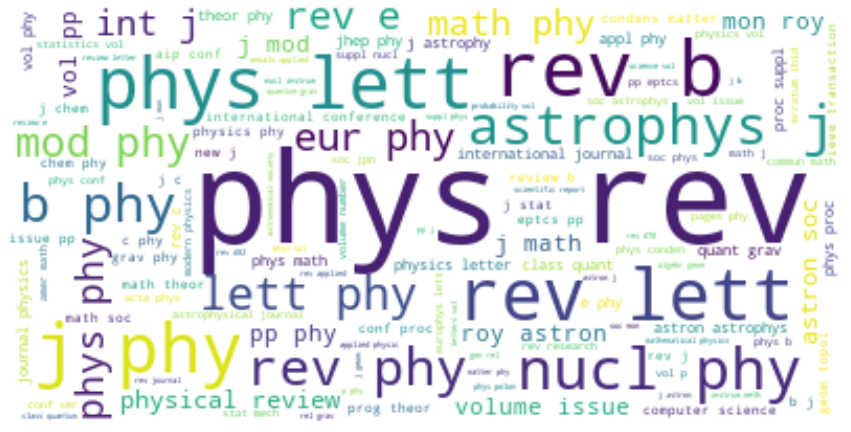

In [447]:
# wordcloud for journal-ref
text = " ".join(i for i in data['journal-ref-clean'])
text = text.replace('nan', '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

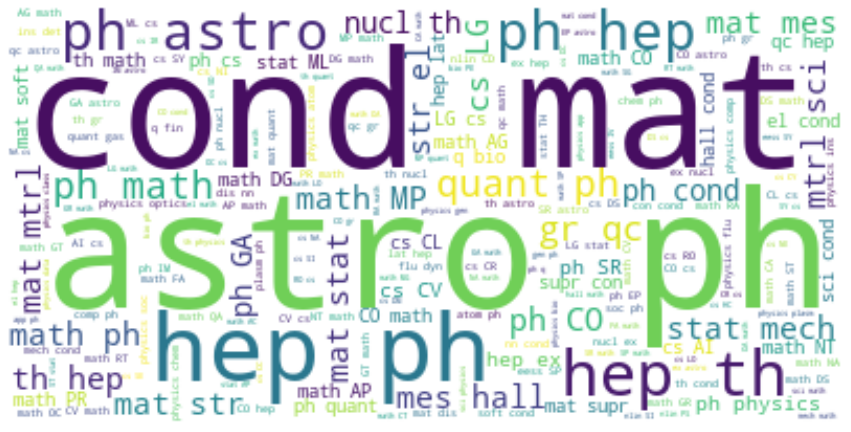

In [448]:
# wordcloud for categories
text = " ".join(i for i in data['categories'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

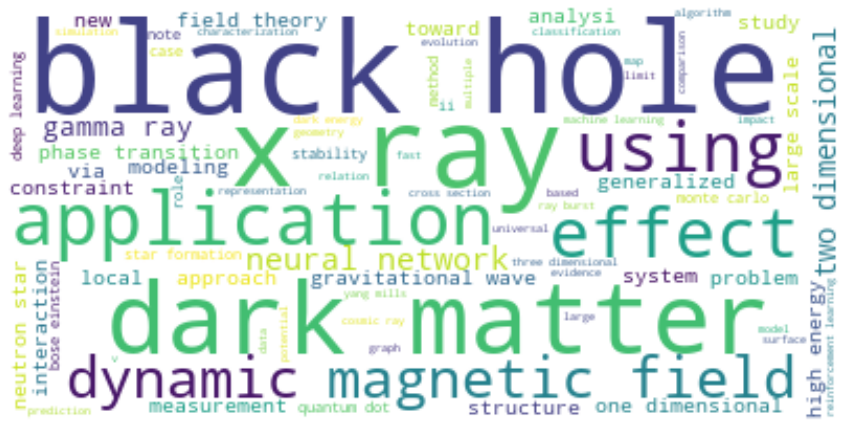

In [449]:
text = " ".join(i for i in data['title-clean'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Top 10 Categories

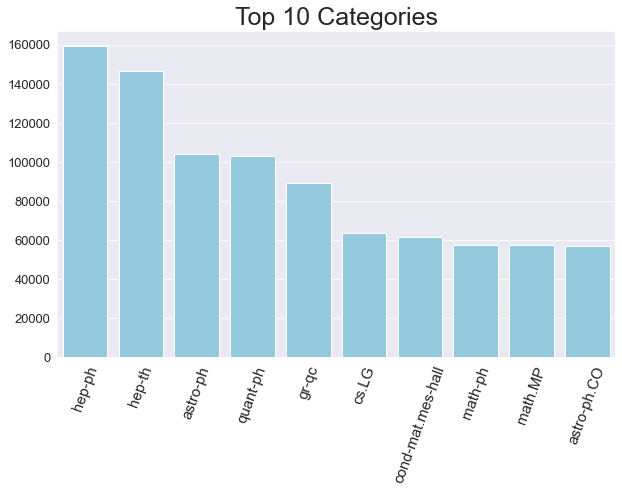

In [451]:
cat_text = " ".join(i for i in data['categories'])
df = pd.DataFrame(cat_text.split(), columns=['cat'])

y = df['cat'].value_counts()[0:10].values
x = df['cat'].value_counts()[0:10].index

plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y, color='skyblue')
locs, labels = plt.xticks(size=15)
plt.yticks(size=13)
plt.setp(labels, rotation=70)
plt.title("Top 10 Categories", size=25)
plt.show()

#### Word2Vec

In [6]:
def myWord2Vec(df, col, new_col):
    # preprocess the data
    data = df[col].apply(gensim.utils.simple_preprocess)

    # initlaize the model
    model = gensim.models.Word2Vec(min_count = 1,size = 100, window = 5)

    # build vocab
    model.build_vocab(data, progress_per=10000)

    # train the model
    model.train(data, total_examples=model.corpus_count, epochs=5)

    # generate vectors
    col_vectors = []
    col_vectors.append(model.wv(i.split()) for i in df[col])

    # create new column in df for vectors
    df[new_col] = col_vectors
    return df.head()

#### Doc2Vec

In [31]:
def myDoc2Vec(df, col, new_col):

    # tokensize and tag the title text
    col_docs = [TaggedDocument(doc.split(' '), [i]) 
                for i, doc in enumerate(df[col])]

    #instantiate model
    model = Doc2Vec(vector_size=64, min_count=1, epochs=5)

    #build vocab
    model.build_vocab(col_docs)

    #train model
    model.train(col_docs, total_examples=model.corpus_count
                , epochs=model.epochs)

    # column to vec
    col_vectors = [model.infer_vector((df[col][i].split(' '))) 
                for i in range(0,len(df[col]))]

    #Create a list of lists
    dtv= np.array(col_vectors).tolist()

    #set list to dataframe column
    df[new_col] = dtv
    return df.head(2)

In [32]:
# df = data[0:100000]
# df.head()

,id,title,comments,journal-ref,categories,title-clean,journal-ref-clean,categories-clean
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,calculation prompt diphoton production cross s...,phys rev d76 013009 2007,hep ph
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,math.CO cs.CG,sparsity certifying graph decompositions,,math co cs cg
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,physics.gen-ph,evolution earth moon system based dark matter ...,,physics gen ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,11 pages,NaN,math.CO,determinant stirling cycle numbers counts unla...,,math co
4,0704.0006,Bosonic characters of atomic Cooper pairs acro...,"6 pages, 4 figures, accepted by PRA",NaN,cond-mat.mes-hall,bosonic characters atomic cooper pairs across ...,,cond mat mes hall


In [35]:
# generate vectors
myDoc2Vec(data, 'title-clean', 'title2vec')
myDoc2Vec(data, 'journal-ref-clean', 'jour2vec')
myDoc2Vec(data, 'categories-clean', 'cat2vec')

C:\Users\Harle\AppData\Local\Temp/ipykernel_16872/1649641439.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = dtv


,id,title,comments,journal-ref,categories,title-clean,journal-ref-clean,categories-clean,title2vec,jour2vec,cat2vec
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,calculation prompt diphoton production cross s...,phys rev d76 013009 2007,hep ph,"[-0.023545878008008003, 0.020534101873636246, ...","[-0.019000962376594543, -0.019619083032011986,...","[0.0067198555916547775, 0.007376315072178841, ..."
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,math.CO cs.CG,sparsity certifying graph decompositions,,math co cs cg,"[-0.029535947367548943, 0.05324733257293701, 0...","[0.0070718806236982346, 0.0028145774267613888,...","[0.03163578361272812, -0.006000959314405918, -..."


#### Histogram/Density Plots

In [49]:
cat = data.cat2vec.tolist()
jour = data.jour2vec.tolist()
title = data.title2vec.tolist()

c:\Users\Harle\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


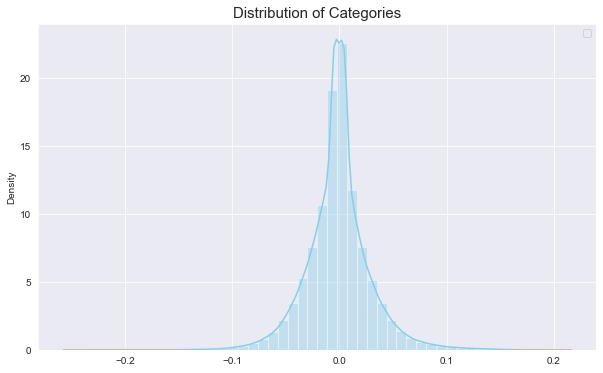

In [101]:
# histogram/density of categories
plt.figure(figsize=(10,6))
sns.distplot(cat, kde=True, hist=True, color='skyblue')
plt.title("Distribution of Categories", size=15)
plt.legend("")
plt.show()

c:\Users\Harle\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


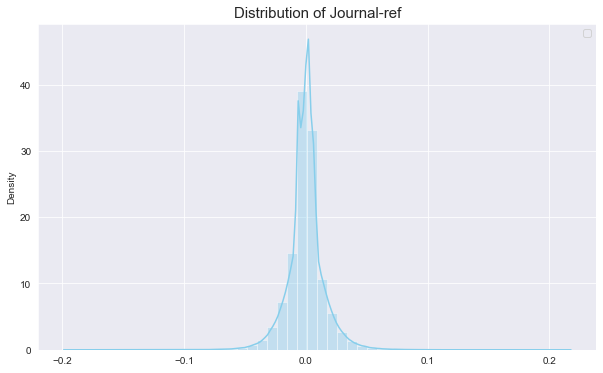

In [56]:
# histogram/density of journal-ref
plt.figure(figsize=(10,6))
sns.distplot(jour, kde=True, hist=True, color='skyblue')
plt.title("Distribution of Journal-ref", size=15)
plt.legend("")
plt.show()

c:\Users\Harle\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


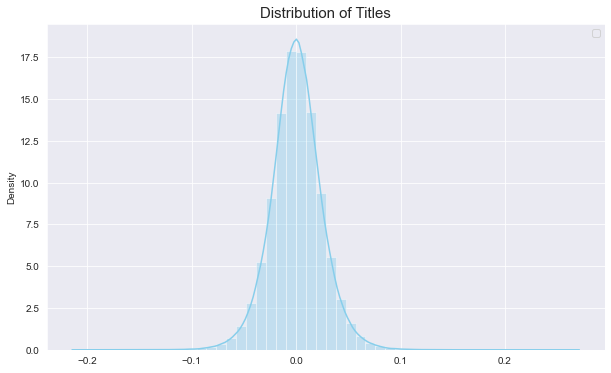

In [59]:
# histogram/density of titles
plt.figure(figsize=(10,6))
sns.distplot(title, kde=True, hist=True, color='skyblue')
plt.title("Distribution of Titles", size=15)
plt.legend("")
plt.show()

#### Relationship - Categories vs. Journal Ref

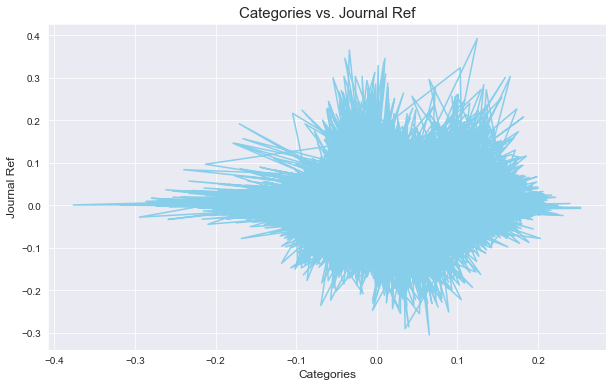

In [66]:
plt.figure(figsize=(10,6))
plt.plot(cat,jour, color='skyblue')
plt.xlabel("Categories", size=12)
plt.ylabel("Journal Ref", size=12)
plt.title("Categories vs. Journal Ref", size=15)
plt.show()

## Diagnostic Analysis

#### Correlation Matrix / Heatmap

In [67]:
# ravel the vectors to a 1D list to calculate correlation
cat2vec = []
for list in data['cat2vec']:
    for number in list:
        cat2vec.append(number)

jour2vec = []
for list in data['jour2vec']:
    for number in list:
        jour2vec.append(number)

title2vec = []
for list in data['title2vec']:
    for number in list:
        title2vec.append(number)

c:\Users\Harle\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
c:\Users\Harle\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


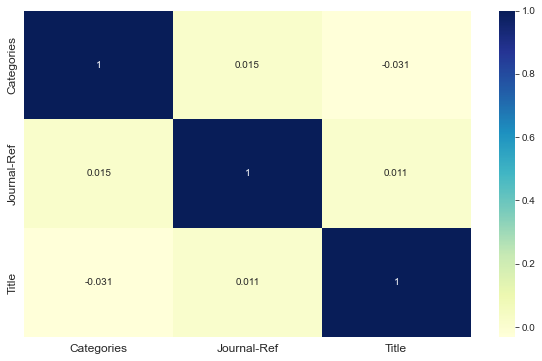

In [68]:
corr_matrix = pd.DataFrame({'Categories': cat2vec, 'Journal-Ref': jour2vec, 'Title': title2vec})

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix.corr(), cmap="YlGnBu", annot=True)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

#### Analyse Dates

In [69]:
# extract dates from journal ref
journal_years = []

for i in data['journal-ref-clean']:
    year = re.findall(r"\b(?:20)\d{2}\b", i)
    # print(year[0])
    # print(int(year[0]))
    # break
    if not year:
        year = [0]
    if int(year[0]) > 2022:
        year = [0]
    journal_years.append(year[0])

data['journal-year'] = journal_years

data['journal-year'] = data['journal-year'].replace(0, np.nan)
data.head(3)

,id,title,comments,journal-ref,categories,title-clean,journal-ref-clean,categories-clean,journal-year
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,calculation prompt diphoton production cross s...,phys rev d76 013009 2007,hep ph,2007
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,math.CO cs.CG,sparsity certifying graph decompositions,,math co cs cg,NaN
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,physics.gen-ph,evolution earth moon system based dark matter ...,,physics gen ph,NaN


c:\Users\Harle\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Articles Published Annually')

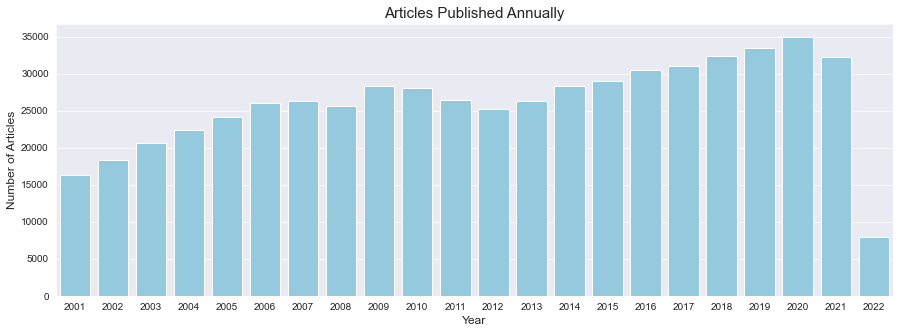

In [70]:
# plot number of articles by year
year_article = data.groupby(['journal-year'])['categories'].count()
# exclude articles with no date extracted
year_article = year_article[1:]

# plt.plot(year_article)
plt.figure(figsize=(15,5))
sns.barplot(year_article.index, year_article.values, color='skyblue')
plt.ylabel("Number of Articles", size=12)
plt.xlabel("Year", size=12)
plt.title("Articles Published Annually", size=15)

In [71]:
# pivot the data to count yearly articles by categories
pivot_data = data[['title', 'categories', 'journal-year']]
year_cat_article_pivot = pd.pivot_table(pivot_data,
                index= 'categories',
                columns = 'journal-year',
                aggfunc='count',
                fill_value="")                

year_cat_article_pivot[10:15]

title                  \
journal-year                                         2000    2001    2002   
categories                                                                  
alg-geom math.AG                                      3.0     2.0     2.0   
alg-geom math.AG math.CO                                              1.0   
astro-ph                                           1557.0  2114.0  2812.0   
astro-ph astro-ph.CO                                                        
astro-ph astro-ph.CO astro-ph.GA physics.plasm-ph                           

                                                                           \
journal-year                                         2003    2004    2005   
categories                                                                  
alg-geom math.AG                                      1.0                   
alg-geom math.AG math.CO                                                    
astro-ph                                           4763.0  4821.0  4458.0   
astro-ph astro-ph.CO                                          1.0     1.0   
astro-ph astro-ph.CO astro-ph.GA physics.plasm-ph                           

                                                                           \
journal-year                                         2006    2007    2008   
categories                                                                  
alg-geom math.AG                                                            
alg-geom math.AG math.CO                                                    
astro-ph                                           5244.0  4306.0  2507.0   
astro-ph astro-ph.CO                                  1.0     1.0     1.0   
astro-ph astro-ph.CO astro-ph.GA physics.plasm-ph                           

                                                           ...                 \
journal-year                                         2009  ... 2013 2014 2015   
categories                                                 ...                  
alg-geom math.AG                                           ...       1.0        
alg-geom math.AG math.CO                                   ...                  
astro-ph                                           1436.0  ...  7.0  3.0  3.0   
astro-ph astro-ph.CO                                  2.0  ...                  
astro-ph astro-ph.CO astro-ph.GA physics.plasm-ph          ...                  

                                                                            \
journal-year                                      2016 2017 2018 2019 2020   
categories                                                                   
alg-geom math.AG                                   1.0                       
alg-geom math.AG math.CO                                                     
astro-ph                                           1.0  1.0  1.0  3.0  1.0   
astro-ph astro-ph.CO                                                         
astro-ph astro-ph.CO astro-ph.GA physics.plasm-ph                            

                                                             
journal-year                                      2021 2022  
categories                                                   
alg-geom math.AG                                             
alg-geom math.AG math.CO                                     
astro-ph                                                2.0  
astro-ph astro-ph.CO                                         
astro-ph astro-ph.CO astro-ph.GA physics.plasm-ph            

[5 rows x 23 columns]

#### Topic Modelling of Titles

In [88]:
# word embeddings
topic_data = []
for i in data['title-clean']:
    words = i.split()
    topic_data.append(words)

In [89]:
# Create Dictionary
id2word = corpora.Dictionary(topic_data)
# Create Corpus
texts = topic_data
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       )
doc_lda = lda_model[corpus]

In [91]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+"topics"+str(num_topics))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+"topics"+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\Harle\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.194277 -0.098151       1        1  16.109645
6      0.125341 -0.084072       2        1  14.285626
5     -0.258648 -0.125208       3        1  13.329031
2      0.019845 -0.164605       4        1  11.579624
7     -0.057263  0.260653       5        1  10.288995
1     -0.097619  0.156639       6        1   8.042877
4      0.131302  0.116071       7        1   7.244128
9      0.020466  0.078114       8        1   6.795967
3      0.120727 -0.043249       9        1   6.387134
8     -0.198428 -0.096191      10        1   5.936974, topic_info=           Term           Freq          Total Category  logprob  loglift
44      quantum  121200.000000  121200.000000  Default  30.0000  30.0000
897           x   38716.000000   38716.000000  Default  29.0000  29.0000
320        spin   39142.000000   39142.000000  Default  28.0000  28.0000
2218   learning   41876.000000   41876.000000  Default  27.0000  27.0000
145     systems   50665.000000   50665.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
150          ii    2950.143064   18650.945123  Topic10  -5.5053   0.9799
480       large    3063.971914   22854.481309  Topic10  -5.4674   0.8145
16    evolution    2833.994477   19399.306864  Topic10  -5.5455   0.9004
17        field    2960.980560   51623.272931  Topic10  -5.5016  -0.0345
442         new    2587.303235   29058.383349  Topic10  -5.6365   0.4053

[938 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
25823      5  0.998457             5g
5865      10  0.996752             6d
752        2  0.000381             ab
752        3  0.000381             ab
752        4  0.003425             ab
...      ...       ...            ...
358        9  0.003714              z
358       10  0.001783              z
20258      1  0.995908  zamolodchikov
4798       3  0.997203            zel
4706       6  0.998552         zumino

[4642 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 3, 8, 2, 5, 10, 4, 9])

#### Rank Words from Titles

In [93]:
# rank words for titles based on word frequncy
title_text = " ".join(i for i in data['title-clean'])
df = pd.DataFrame(title_text.split(), columns=['title'])
df['title'].value_counts()

quantum       95160
model         73059
theory        53043
field         45529
using         45035
              ...  
nouse             1
randdm            1
scramlbing        1
wrod              1
lnni2b2c          1
Name: title, Length: 158668, dtype: int64

## Action

#### Top 10 Words

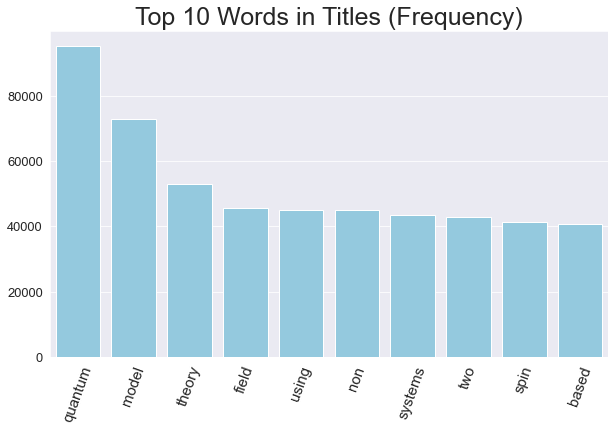

In [94]:
# top 10 words from titles 
y = df['title'].value_counts()[0:10].values
x = df['title'].value_counts()[0:10].index

plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y, color='skyblue')
locs, labels = plt.xticks(size=15)
plt.yticks(size=13)
plt.setp(labels, rotation=70)
plt.title("Top 10 Words in Titles (Frequency)", size=25)
plt.show()

In [95]:
top10 = x

top10

Index(['quantum', 'model', 'theory', 'field', 'using', 'non', 'systems', 'two',
       'spin', 'based'],
      dtype='object')

#### Recommend Journal

In [96]:
def recommend_journals(list_of_words):
    recommendations_list = []
    for word in top10:
        recommendation = data[data['title-clean'].str.contains(word, case=False, na=False)]['journal-ref']
        recommendations_list.append(recommendation[recommendation.notnull()].tolist()[0])
    return pd.DataFrame({'Word': list_of_words, 'Recommended Journal': recommendations_list})

In [97]:
recommend_journals( top10)

,Word,Recommended Journal
0,quantum,"Phys.Rev.D76:044016,2007"
1,model,"Annals of Applied Probability 2008, Vol. 18, N..."
2,theory,"J. Math. Kyoto Univ., 48 (2008), 857-893."
3,field,"Int.J.Mod.Phys.A23:3685-3705,2008"
4,using,"Class.Quant.Grav.24:S541-S550,2007"
5,non,"Phys. Rev. Lett. 99, 087402 (2007)"
6,systems,"Class.Quant.Grav.24:S541-S550,2007"
7,two,J. Phys.: Condens. Matter 20 (2008) 055214
8,spin,"JHEP 0705:034,2007"
9,based,"RIMS Kokyuroku, No.1551, pp.57-62 (2007)"
